In [45]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.core.display import display, HTML
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go

%config InlineBackend.figure_format = "svg"

display(HTML("""
<style>
.output {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
div.output_area .rendered_html table {
    margin-left: auto;
    margin-right: auto;
}
</style>
"""))

In [46]:
ace_data = pd.read_pickle("../data/../data/ace_data_prepped.pkl")

# ACE Project - should really be centered

# The Data:

The dataset consists of 18 dependent features that are potentially predictive of the likelihood a child can be
treated in a community asthma clinic:
* **referral_from:** The clinical setting from which the ACE referral comes - *A&E / CCDE / ED / GP*
* **Age:** Patient age in years
* **Address:** The postcode area of the patient's address - *BD1 / BD2 etc.*
* **ethnicity:** The patients reported ethnicity (appears to be free-text i.e. not chosen from
pre-determined options)
* **gender:** Simple biological gender - *M / F*
* **referral_date:** Time of year of the referral - *spring / summer / autumn / winter*
* **referral_time:** Time of day of the referral - *morning / afternoon / evening*
* **illness_severtiy:** Reported severity of the child's illness - *mild / moderate*
* **activity_level:** Level of physical activity typical of the patient - *usual / lower*
* **gut_feeling:** Referrer's gut feeling of the child's health - *well / low concern / unwell*
* **ox_sat:** The patients blood oxygen saturation level
* **resp_rate:** The patient's respiratory rate (breaths per minute)
* **heart_rate:** The patients heart rate (beats per minute)
* **temp:** Patient body temperature (degrees C)
* **sepsis:** Any sepsis red flags - *none noted / low level*
* **safeguarding:** Are there any safeguarding concerns with the child - *Y / N*
* **drug_allergy**: Does the patient have drug allergy? *Y / N*
* **food_allergy**: Does the patient have food allergy? *Y / N*
* **other_allergy**: Does the patient have another allergy? *Y / N*

The following is a quick analysis of proportion of children that can be treated in the community, broken down by each
 of these features

## Categorical Features

Below we break down each of the categorical features into discrete categories, and show the proportion
 of
children that require hospital treatment from each category.
Overall, **16.43%** of patients in the dataset required hospital treatment - <span style="color:green">Values in
green</span> signify a category with proportion lower than this mean</i> -
<span style="color:red">red values</span> signify a proportion higher than the sample mean:

In [47]:
skip_features = ["id", "hospital_reqd", "age", "heart_rate", "resp_rate",
                 "ox_sat", "temp", "ethnicity"]

cat_feature_stats = pd.DataFrame()
chi2_stats = pd.DataFrame()
for feature in ace_data.columns:

    if feature in skip_features:
        continue

    hospital_required_counts = (ace_data[[feature, "hospital_reqd"]]
                                .groupby([feature, "hospital_reqd"],
                                         as_index=False)
                                .size()
                                .pivot(index=feature,
                                       columns="hospital_reqd",
                                       values="size").fillna(0))

    chi2, p, dof, expected = chi2_contingency(hospital_required_counts.values)
    chi2_results = pd.DataFrame({ "chi2": chi2, "p": p, "dof": dof },
                                index=[feature])

    chi2_stats = pd.concat([chi2_stats, chi2_results])

    # skip agg feature analysis for address (too many categories)
    if feature == "address":
        continue

    feature_df = (ace_data[["hospital_reqd", feature]]
                  .groupby(feature)
                  .agg(["mean", np.std, stats.sem, "count"])).hospital_reqd

    idx_tuples = [(feature_df.index.name, cat)
                  for cat in feature_df.index.categories]

    new_idx = pd.MultiIndex.from_tuples(idx_tuples, names=["feature", "values"])

    feature_df.set_index(new_idx, inplace=True)
    cat_feature_stats = pd.concat([cat_feature_stats, feature_df])

cat_feature_stats = cat_feature_stats.rename(columns={
    "mean": "Mean",
    "std": "Standard Dev",
    "sem": "Standard Error",
    "count": "Count"
})


rnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=rnorm, cmap=red_cmap)

gnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.15)
green_cmap = sns.color_palette("Greens", as_cmap=True)
green_m = cm.ScalarMappable(norm=gnorm, cmap=green_cmap)

def highlight_low_high(df):
    if df["Mean"] < ace_data.hospital_reqd.mean():
        mean_diff = ace_data.hospital_reqd.mean() - df["Mean"] + 0.02
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(green_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4
    else:
        mean_diff = df["Mean"] - ace_data.hospital_reqd.mean()
        mean_diff = min(mean_diff, 0.12)
        rgba_value = tuple(np.array(red_m.to_rgba(mean_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * 4

cat_feature_stats.iloc[:30,:].style.apply(highlight_low_high,
                              axis=1)

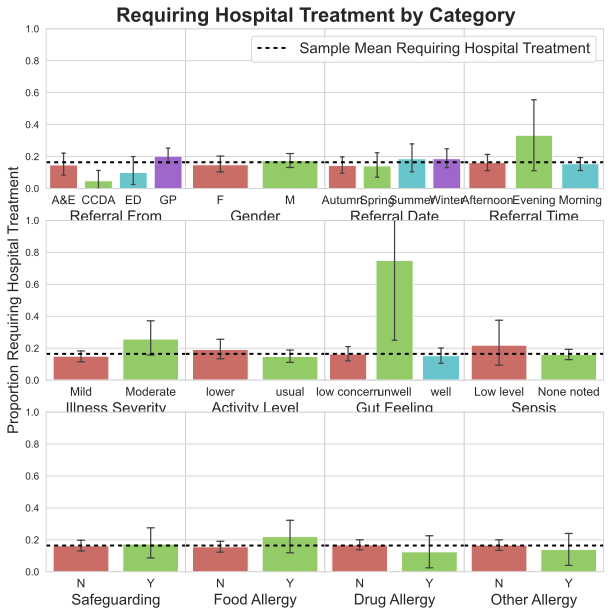

In [48]:
bar_plot_features = ['referral_from', 'gender', 'referral_date', 'referral_time',
                     'illness_severity', 'activity_level', 'gut_feeling',
                     'sepsis', 'safeguarding', 'food_allergy', 'drug_allergy',
                     'other_allergy']

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(10,10))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             y=0.91,
             size=20,
             weight="bold")

for n, feature in enumerate(bar_plot_features):
    row, col = int(np.floor(n/4)), n%4
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=2,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label, size=15)
    ax.tick_params(axis='x', which='major', labelsize=12)
    if row == 1:
        ax.set_ylabel("Proportion Requiring Hospital Treatment", size=15)
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if col == 3 and row == 0:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=2)
        ax.legend(handles=[mean_line],
                  fontsize=15)

Address Feature (too many categories to be included with other grouped analysis above):

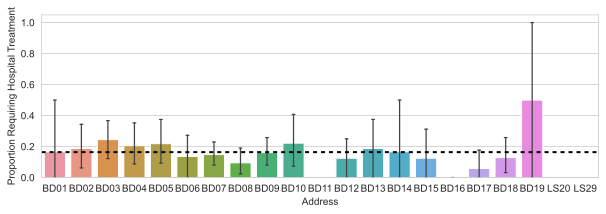

In [49]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,3))
fig = sns.barplot(data=ace_data,
                  x="address",
                  y="hospital_reqd",
                  errwidth=1.25,
                  capsize=.1)
fig.set_xlabel("Address")
fig.set_ylabel("Proportion Requiring Hospital Treatment")
line = fig.axhline(ace_data.hospital_reqd.mean(),
                  color="black",
                  linewidth=2,
                  dashes=(2,2))

It's (hopefully!) obvious there is a lot of variability in the data. The mean "hospital_required" figure for each
category show a high variance / standard deviation and the errors for each
category
overlap significantly with
one
another (and the sample mean). This is also reflected in a simple chi<sup>2</sup> test:

### Pearson's Chi<sup>2</sup> Significance figures

<span style="color: green">Figures in green</span> have a p value < 0.05, <span style="color: red">those in
red</span> have a p value greater than 0.05, the shade of red signifying the degree of the difference:

In [50]:
pnorm = mpl.colors.Normalize(vmin=0.0,vmax=0.5)
red_cmap = sns.color_palette("Reds", as_cmap=True)
red_m = cm.ScalarMappable(norm=pnorm, cmap=red_cmap)

def highlight_significant(df, ncol):
    if df.p < 0.05:
        return ["background-color: #248c46"] * ncol
    else:
        p_diff = df.p - .05
        p_diff = min(p_diff, 0.4)
        rgba_value = tuple(np.array(red_m.to_rgba(p_diff))*255)
        return [f"background-color: rgba{rgba_value}"] * ncol

(chi2_stats.iloc[:13,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
gut_feeling,10.201133,0.006093,2
referral_from,10.675960,0.013614,3
illness_severity,4.273838,0.038703,1
referral_time,3.931710,0.140036,2
activity_level,1.267564,0.260224,1
food_allergy,1.101011,0.294044,1
gender,0.439708,0.507263,1
sepsis,0.374771,0.540415,1
drug_allergy,0.227928,0.633065,1
referral_date,1.711824,0.634308,3


Overall it is clear that, given this high level of variance, there isn't a statistically significant correlation
between
many of the dataset features and
the hospital required target. It's difficult to say if there is a real difference in the outcomes for most of
the features and the data
suggest a strong
possibility the  observed differences between categories
occur by
chance. That's not to say there isn't a difference, just that we can't be certain of a precise difference from the data.

Also some notes on the significant features:

**gut_feeling** / **illness_severity** - It's certainly reassuring that the opinion of medical professionals is
significant! That said, very few patients are assigned to the most predictive categories i.e. a patient being deemed
"unwell" is a very strong predictor, but only a minute fraction of the examples are assigned this category. As such,
these features can't be used to divide the vast majority of the data.

**referral_from** - I'm there may be a "confounding element" to this feature i.e. there is some out-of-sample selection
happening that means a greater proportion of patients seen at the GP (an the opposite for the other categories) are
expected to require hospital
treatment.
As a
 hypothetical example, the most ill patients treated at A&E may be admitted to hospital without referral to ACE (and
 so aren't featured in the data), so only the milder cases are referred from A&E to ACE. *Maybe Mat can shed some more
  light on this?*

## Numerical Features

The story is similar with the numeric features:

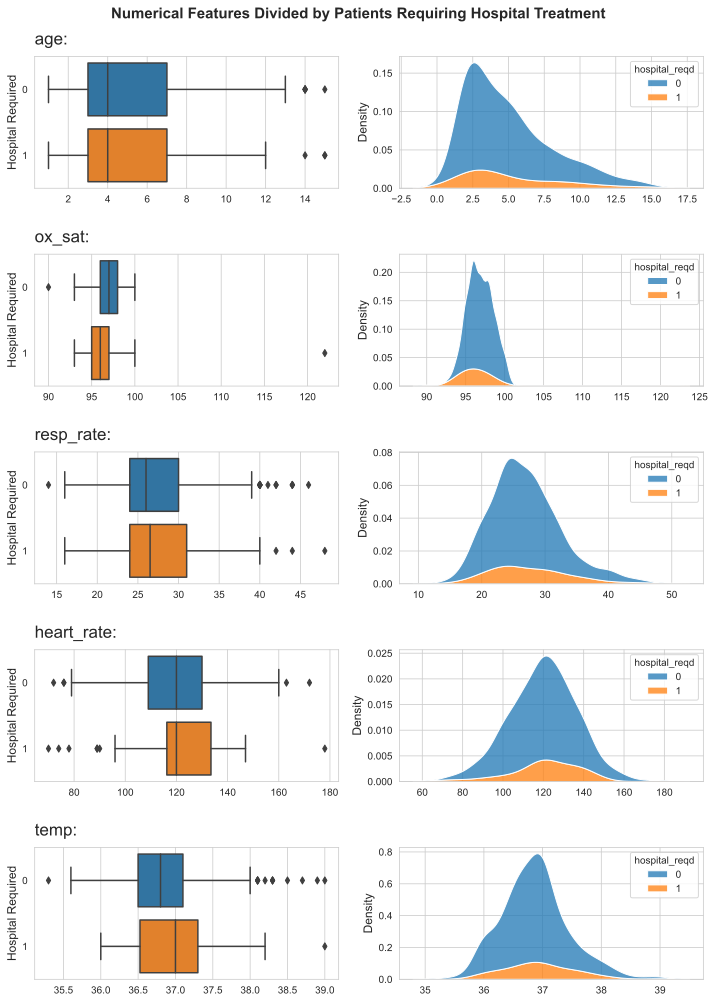

In [51]:
num_features = ['age', 'ox_sat', 'resp_rate', 'heart_rate', 'temp']

fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(12,17))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Numerical Features Divided by Patients Requiring Hospital Treatment",
             y=0.92,
             size=15,
             weight="bold")
for n, feature in enumerate(num_features):
    ax1 = sns.boxplot(data=ace_data,
                      y="hospital_reqd",
                      x=feature,
                      orient="h",
                      ax=axs[n, 0])
    ax1.set_xlabel("")
    ax1.set_ylabel("Hospital Required", size=12)
    ax1.set_title(f"{feature}:", loc="left", pad=12, fontsize=17)
    ax2 = sns.kdeplot(data=ace_data,
                      x=feature,
                      hue="hospital_reqd",
                      multiple="stack",
                      ax=axs[n,1])
    ax2.set_xlabel("")
    ax2.set_ylabel("Density", size=12)



In [52]:
pearsons_r_stats = {
    "r": [],
    "p": []
}

for feature in num_features:
    feature_data = ace_data[[feature, "hospital_reqd"]].dropna()
    r, p = stats.pearsonr(feature_data[feature],
                          feature_data.hospital_reqd)
    pearsons_r_stats["r"].append(r)
    pearsons_r_stats["p"].append(p)

pearsons_r_stats = (pd.DataFrame(pearsons_r_stats, index=num_features)
                  .sort_values("p"))
pearsons_r_stats.style.apply(highlight_significant, ncol=2, axis=1)


,r,p
ox_sat,-0.079778,0.077991
temp,0.064907,0.175115
resp_rate,0.056062,0.216371
heart_rate,0.045200,0.318036
age,0.032073,0.474706


## Engineered features

### Ethnicity


In [53]:
cat_feature_stats.iloc[30:36,:].style.apply(highlight_low_high,
                              axis=1)

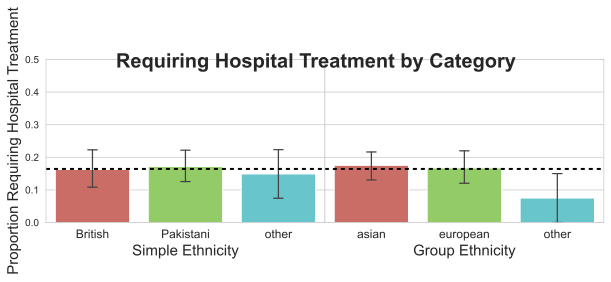

In [54]:

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             y=0.91,
             size=20,
             weight="bold")

ax1 = sns.barplot(data=ace_data, x="simple_ethnicity", y="hospital_reqd", errwidth=1.25, capsize=.1, ax=axs[0], palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
ax1.axhline(ace_data.hospital_reqd.mean(), color="black", linewidth=2, dashes=(2,2))
ax1.set_xlabel("Simple Ethnicity", size=15)
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.set_ylabel("Proportion Requiring Hospital Treatment", size=15)

ax1.set(ylim=(0,.5))

ax2 = sns.barplot(data=ace_data, x="group_ethnicity", y="hospital_reqd", errwidth=1.25, capsize=.1, ax=axs[1],
                  palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
ax2.axhline(ace_data.hospital_reqd.mean(), color="black", linewidth=2, dashes=(2,2))
ax2.set_xlabel("Group Ethnicity", size=15)
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.set(yticklabels=[], ylabel="")
ax2.set(ylim=(0,.5))
mean_line = mpl.lines.Line2D([], [], color='black', label='Sample Mean Requiring Hospital Treatment', dashes=(2,2), linewidth=2)
ax.legend(handles=[mean_line], fontsize=15)

In [55]:
(chi2_stats.iloc[13:15,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
group_ethnicity,2.576695,0.275726,2
simple_ethnicity,0.256294,0.879724,2


### ACE referral criteria


In [56]:
cat_feature_stats.iloc[36:49,:].style.apply(highlight_low_high,
                              axis=1)

(0.0, 1.0, 0.0, 1.0)

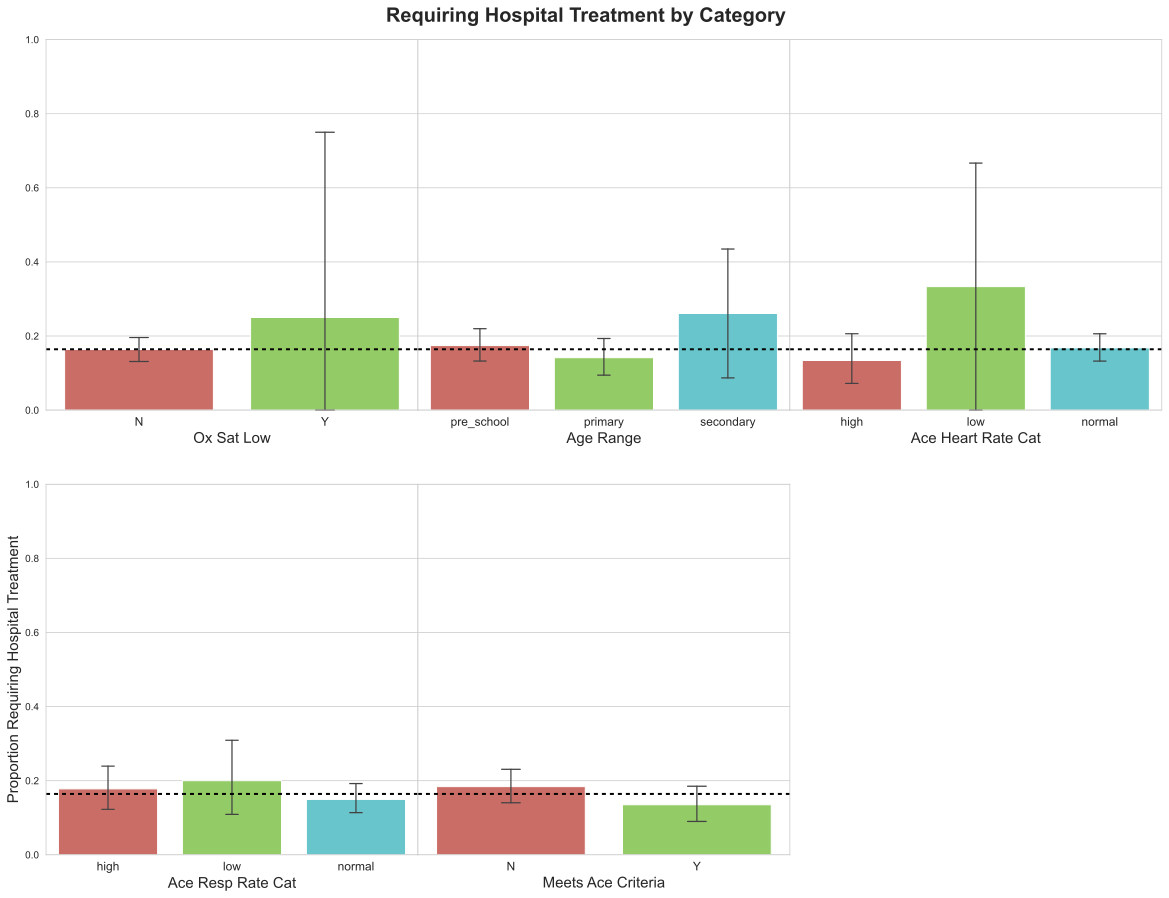

In [57]:
ace_features = ["ox_sat_low", "age_range", "ace_heart_rate_cat", "ace_resp_rate_cat",
                "meets_ace_criteria"]

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,15))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             y=0.91,
             size=20,
             weight="bold")

for n, feature in enumerate(ace_features):
    row, col = int(np.floor(n/3)), n%3
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[row, col],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=2,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label, size=15)
    ax.tick_params(axis='x', which='major', labelsize=12)
    if row == 1:
        ax.set_ylabel("Proportion Requiring Hospital Treatment", size=15)
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if col == 3 and row == 0:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=2)
        ax.legend(handles=[mean_line],
                  fontsize=15)

axs[1,2].axis("off")

In [58]:
(chi2_stats.iloc[15:20,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))

,chi2,p,dof
meets_ace_criteria,1.749478,0.185942,1
ace_heart_rate_cat,2.558079,0.278304,2
age_range,2.553815,0.278898,2
ace_resp_rate_cat,1.180700,0.554133,2
ox_sat_low,0.045418,0.831238,1


### Advanced Paediatric Life Support (APLS) normal values

In [59]:
cat_feature_stats.iloc[49:,:].style.apply(highlight_low_high,
                              axis=1)

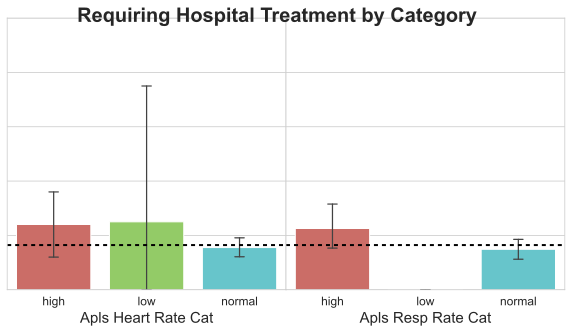

In [60]:

ace_features = ["apls_heart_rate_cat", "apls_resp_rate_cat"]

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
plt.subplots_adjust(wspace=0)
fig.suptitle("Requiring Hospital Treatment by Category",
             y=0.91,
             size=20,
             weight="bold")

for n, feature in enumerate(ace_features):
    ax = sns.barplot(data=ace_data,
                     x=feature,
                     y="hospital_reqd",
                     errwidth=1.25,
                     capsize=.1,
                     ax=axs[n],
                     palette=sns.color_palette("hls", 4))
    # draw line of overall mean hospital admissions
    line = ax.axhline(ace_data.hospital_reqd.mean(),
                      color="black",
                      linewidth=2,
                      dashes=(2,2))
    x_label = feature.replace("_", " ").title()
    ax.set_xlabel(x_label, size=15)
    ax.tick_params(axis='x', which='major', labelsize=12)
    if row == 1:
        ax.set_ylabel("Proportion Requiring Hospital Treatment", size=15)
    else:
        ax.set_ylabel("")

    # set y axis range to 0-1 for all subplots
    ax.set(ylim=(0,1))
    if col != 0:
        ax.set(yticklabels=[],
               ylabel="")
    if col == 3 and row == 0:
        mean_line = mpl.lines.Line2D([], [],
                                     color='black',
                                     label='Sample Mean Requiring Hospital Treatment',
                                     dashes=(2,2),
                                     linewidth=2)
        ax.legend(handles=[mean_line],
                  fontsize=15)

In [61]:
(chi2_stats.iloc[20:,:].sort_values("p")
 .style.apply(highlight_significant, ncol=3, axis=1))


,chi2,p,dof
apls_resp_rate_cat,4.651088,0.097730,2
apls_heart_rate_cat,2.577296,0.275643,2
